In [1]:
import os
import random
import string


def generate_text_files():
    sizes = [1 * 1024, 10 * 1024, 25 * 1024]
    directory = 'test'
    os.makedirs(directory, exist_ok=True)
    
    for size in sizes:
        # Generate random text file
        random_filename = os.path.join(directory, f'random_{size//1024}kb.txt')
        with open(random_filename, 'w') as f:
            f.write(''.join(random.choices(string.ascii_letters + string.digits, k=size)))
        
        # Generate not so random text file
        not_random_filename = os.path.join(directory, f'not_random_{size//1024}kb.txt')
        with open(not_random_filename, 'w') as f:
            f.write('A' * size)

generate_text_files()

Decompressing: 100%|██████████| 330/330 [00:00<00:00, 164717.40it/s]


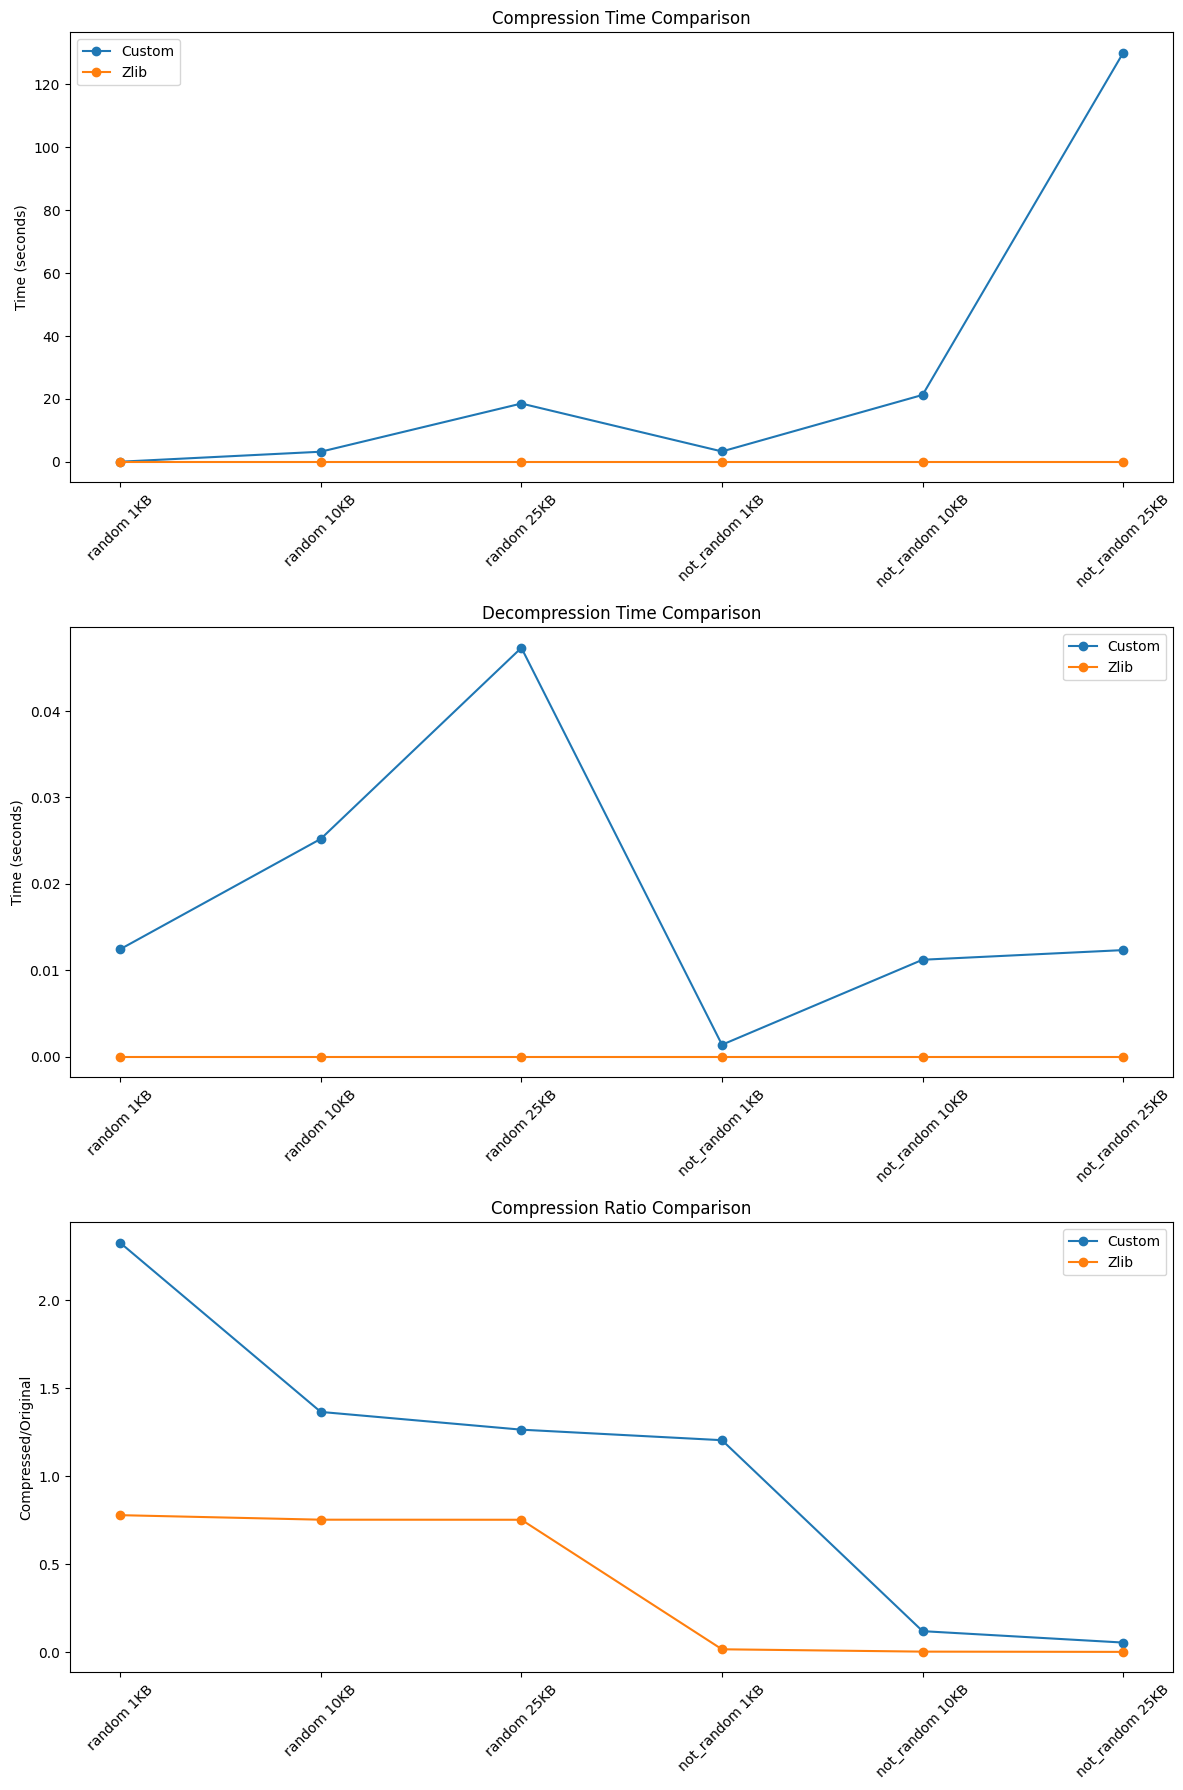

In [2]:
import time
import zlib
import matplotlib.pyplot as plt

from deflate import compress_file, decompress_file

def compare_results():
    """
    For each test file (text with sizes 1KB, 10KB, 25KB),
    re-run compression (even if files already exist) to measure timing,
    then compute the compression ratio from file sizes.
    Also, measure decompression time.
    """
    file_types = ['random', 'not_random']
    sizes = [1, 10, 25]  # in KB
    directory = 'test'
    # Prepare a dictionary to hold our benchmark data
    results = {
       'custom': {'compression_time': [], 'decompression_time': [], 'ratio': []},
       'zlib': {'compression_time': [], 'decompression_time': [], 'ratio': []},
       'labels': []  # labels for x-axis: e.g., "random 1KB", "not_random 25KB", etc.
    }

    for file_type in file_types:
        for size in sizes:
            label = f"{file_type} {size}KB"
            results['labels'].append(label)
            input_path = os.path.join(directory, f"{file_type}_{size}kb.txt")
            custom_compressed = os.path.join(directory, f"{file_type}_{size}kb.custom.deflate")
            zlib_compressed = os.path.join(directory, f"{file_type}_{size}kb.zlib")
            
            # --- Custom Implementation ---
            # Measure compression time (this call will overwrite the file)
            start = time.time()
            compress_file(input_path, custom_compressed)
            comp_time_custom = time.time() - start
            
            # Measure decompression time for custom (write to a temporary file)
            temp_decompressed = os.path.join(directory, f"{file_type}_{size}kb.custom.decompressed")
            start = time.time()
            decompress_file(custom_compressed, temp_decompressed)
            decomp_time_custom = time.time() - start
            # Clean up the temporary decompressed file
            if os.path.exists(temp_decompressed):
                os.remove(temp_decompressed)
            
            # Get file sizes and calculate ratio
            original_size = os.path.getsize(input_path)
            custom_size = os.path.getsize(custom_compressed)
            ratio_custom = custom_size / original_size
            
            results['custom']['compression_time'].append(comp_time_custom)
            results['custom']['decompression_time'].append(decomp_time_custom)
            results['custom']['ratio'].append(ratio_custom)
            
            # --- ZLIB Implementation ---
            with open(input_path, 'rb') as f:
                data = f.read()
            # Measure zlib compression time
            start = time.time()
            zlib_data = zlib.compress(data, level=zlib.Z_BEST_COMPRESSION)
            comp_time_zlib = time.time() - start
            # Write out the compressed data (overwriting if necessary)
            with open(zlib_compressed, 'wb') as f:
                f.write(zlib_data)
                
            # Measure zlib decompression time (in memory)
            start = time.time()
            _ = zlib.decompress(zlib_data)
            decomp_time_zlib = time.time() - start
            
            zlib_size = os.path.getsize(zlib_compressed)
            ratio_zlib = zlib_size / original_size
            
            results['zlib']['compression_time'].append(comp_time_zlib)
            results['zlib']['decompression_time'].append(decomp_time_zlib)
            results['zlib']['ratio'].append(ratio_zlib)
            
    return results

def plot_results(results):
    """
    Create three plots:
      - Compression time comparison.
      - Decompression time comparison.
      - Compression ratio comparison.
    The x-axis shows each test file (e.g., "random 1KB", "not_random 25KB", etc.)
    """
    labels = results['labels']
    x = range(len(labels))
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # Compression Time Plot
    axs[0].plot(x, results['custom']['compression_time'], marker='o', label='Custom')
    axs[0].plot(x, results['zlib']['compression_time'], marker='o', label='Zlib')
    axs[0].set_title('Compression Time Comparison')
    axs[0].set_ylabel('Time (seconds)')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(labels, rotation=45)
    axs[0].legend()
    
    # Decompression Time Plot
    axs[1].plot(x, results['custom']['decompression_time'], marker='o', label='Custom')
    axs[1].plot(x, results['zlib']['decompression_time'], marker='o', label='Zlib')
    axs[1].set_title('Decompression Time Comparison')
    axs[1].set_ylabel('Time (seconds)')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels, rotation=45)
    axs[1].legend()
    
    # Compression Ratio Plot
    axs[2].plot(x, results['custom']['ratio'], marker='o', label='Custom')
    axs[2].plot(x, results['zlib']['ratio'], marker='o', label='Zlib')
    axs[2].set_title('Compression Ratio Comparison')
    axs[2].set_ylabel('Compressed/Original')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(labels, rotation=45)
    axs[2].legend()
    
    plt.tight_layout()
    plt.savefig('benchmark_comparison.png')
    plt.show()

results = compare_results()
plot_results(results)